## Summary

Data downloaded from:
http://pla.esac.esa.int/pla/#cosmology
(choose 'Cosmology', then 'CMB angular power spectra')

The data corresponds to Figure 1 in the famous paper 13: https://www.aanda.org/articles/aa/full_html/2016/10/aa25830-15/aa25830-15.html
Other data in the .fits files are from Fig. 3. Also, the .txt files give the unbinned versions and the separate columns.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rc('font', size=22)
plt.rc('text', usetex=True)

In [2]:
from astropy.io import fits # If this yields an ImportError, go to your terminal and tell it `conda install astropy`

## Functions

### Extracting the measured data

In [3]:
def extract_column(f, column_index):
    '''
    Give the fits file and the column index that you want to extract.
    '''
    d = f[column_index]
    arr = np.array(d.data)
    cols = d.columns.names

    # Either one L value or a range
    # Take the average if it is a range
    if 'ELL' not in cols:
        if 'LMIN' in cols and 'LMAX' in cols:
            arr['ELL'] = 0.5 * (arr['LMIN'] + arr['LMAX'])
        else:
            raise ValueError('Error: did not find ELL or LMIN and LMAX in columns.')
    x = arr['ELL']
    y = arr['D_ELL']
    
    # Depending on the data, the error is two-sided or not.
    if 'ERR' in cols:
        dy = (arr['ERR'], arr['ERR'])
    elif 'ERRUP' in cols and 'ERRDOWN' in cols:
        dy = (arr['ERRDOWN'], arr['ERRUP'])
    else:
        raise ValueError('Error: did not find ERR or ERRUP and ERRDOWN in columns.')
    
    return x, y, dy
    

In [4]:
def extract_data(f, indices = (1, 7)):
    # First extract all outputs
    xydys = []
    for index in indices:
        xydys.append(extract_column(f, index))
    x = np.concatenate([xydy[0] for xydy in xydys])
    y = np.concatenate([xydy[1] for xydy in xydys])
    dydown = np.concatenate([xydy[2][0] for xydy in xydys])
    dyup = np.concatenate([xydy[2][0] for xydy in xydys])
    dy = (dydown, dyup)
    return x, y, dy

In [5]:
def read_curve(fn):
    '''
    Function for reading files produced by WebPlotDigitizer
    https://apps.automeris.io/wpd/
    '''
    def stringformatter(s):
        s = str(s)
        s = s.replace(';', '')
        s = s.replace(',', '.')
        s = s.replace("b'", '')
        s = s.replace("'", '')
        return s
    d = np.loadtxt(fn, converters={i: stringformatter for i in (0,1)})
    return d[:, 0], d[:, 1]

### Plotting

In [6]:
import matplotlib as mpl
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(mpl.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], **kwargs))

## Reading data

### Extract the measured data

In [7]:
fits_fn = 'data/CMB/COM_PowerSpect_CMB_R2.02.fits'
f = fits.open(fits_fn)
x,y, dy = extract_data(f)

### Extracting the fit data

The fit data is *not* the .fits file, actually. Hmm.

In [8]:
theory = np.loadtxt('data/CMB/COM_PowerSpect_CMB-base-plikHM-TT-lowTEB-minimum-theory_R2.02.txt')

In [9]:
xt = theory[:, 0]
yt = theory[:, 1]

### No DM predictions

In [10]:
xt1, yt1 = read_curve('data/CMB/teves_no_sterile_neutrino.txt')
xt2, yt2 = read_curve('data/CMB/teves_with_sterile_neutrino.txt')

In [11]:
def shift(arr, n):
    '''
    Shift an array. Used in moving average filter
    '''
    if n == 0:
        return np.array(arr)
    if n < 0:
        return np.concatenate([np.ones(-n) * arr[0], arr[:n]])
    if n > 0:
        return np.concatenate([arr[n:], np.ones(n) * arr[-1]])
    
def mv_avg(arr, order=1):
    return np.average([shift(arr, n) for n in np.arange(-order, order + 1, 1)], axis=0)

In [12]:
# yt1 = mv_avg(yt1, 1)

## Plots!

### Fancy plot of the TT power spectrum

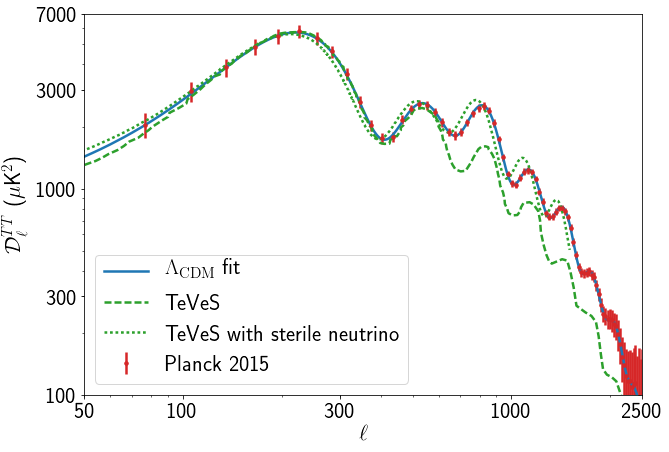

In [14]:

show_inset = False
error_mult = 5
lw = 2.5

fig = plt.figure()
plt.plot(xt, yt, label=r'$\Lambda_{\rm CDM}$ fit', lw=lw)
plt.errorbar(x, y, error_mult * np.array(dy), marker='.', markersize=7, ls='None', label='Planck 2015', 
             color='C3', lw=lw)
plt.plot(xt1, mv_avg(yt1, 1), color='C2', ls='--', label='TeVeS', lw=lw)
plt.plot(xt2, mv_avg(yt2, 0), color='C2', ls='dotted', label='TeVeS with sterile neutrino', lw=lw)

plt.yscale('log')
plt.xscale('log')

plt.xlim(50, 2500)
plt.ylim(100, 7e3)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\mathcal{D}^{TT}_{\ell}$ ($\mu$K$^2$)')
xticks = [50, 100, 300, 1000, 2500]
yticks =  [100, 300, 1000, 3000, 7000]
plt.xticks(xticks, xticks)
plt.yticks(yticks, yticks)
        
plt.savefig('plots/planck.pdf', bbox_inches='tight')

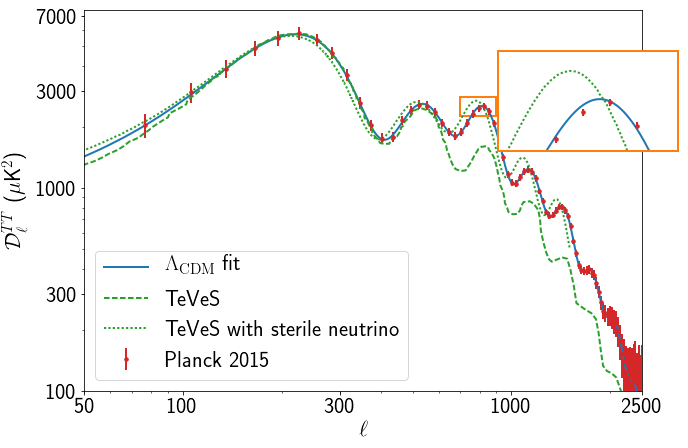

In [79]:

show_inset = True
error_mult = 5
lw = 2

fig = plt.figure()
plt.plot(xt, yt, label=r'$\Lambda_{\rm CDM}$ fit', lw=lw)
plt.errorbar(x, y, error_mult * np.array(dy), marker='.', markersize=7, ls='None', label='Planck 2015', 
             color='C3', lw=lw)
plt.plot(xt1, mv_avg(yt1, 1), color='C2', ls='--', label='TeVeS', lw=lw)
plt.plot(xt2, mv_avg(yt2, 0), color='C2', ls='dotted', label='TeVeS with sterile neutrino', lw=lw)

plt.yscale('log')
plt.xscale('log')

plt.xlim(50, 2500)
plt.ylim(100, 7.5e3)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\mathcal{D}^{TT}_{\ell}$ ($\mu$K$^2$)')
xticks = [50, 100, 300, 1000, 2500]
yticks =  [100, 300, 1000, 3000, 7000]
plt.xticks(xticks, xticks)
plt.yticks(yticks, yticks)


if show_inset:
    x_inset = (700, 900)
    y_inset = (2250, 2800)
    lw_spine = 2
    c_spine = 'C1'
    left, bottom, width, height = [0.7, 0.6, 0.25, 0.2]

    draw_box(x_inset, y_inset, facecolor='None', edgecolor=c_spine, lw=lw_spine)
    ax2 = fig.add_axes([left, bottom, width, height])
    plt.sca(ax2)
    plt.plot(xt, yt, label=r'$\Lambda_{\rm CDM}$ fit', lw=lw)
    plt.plot(xt1, mv_avg(yt1, 1), color='C2', ls='--', label='TeVes', lw=lw)
    plt.plot(xt2, mv_avg(yt2, 0), color='C2', ls='dotted', label='TeVes with sterile neutrino', lw=lw)
    plt.errorbar(x, y, dy, marker='.', markersize=7, ls='None', color='C3', lw=lw)
    plt.xlim(x_inset)
    plt.ylim(y_inset)
    plt.xticks([])
    plt.yticks([])

    for spine in ax2.spines.values():
            spine.set_edgecolor('C1')
            spine.set_lw(lw_spine)
        
# plt.savefig('plots/planck.pdf', bbox_inches='tight')

## Other plots

The easy version you may be familiar with.

(0, 6100)

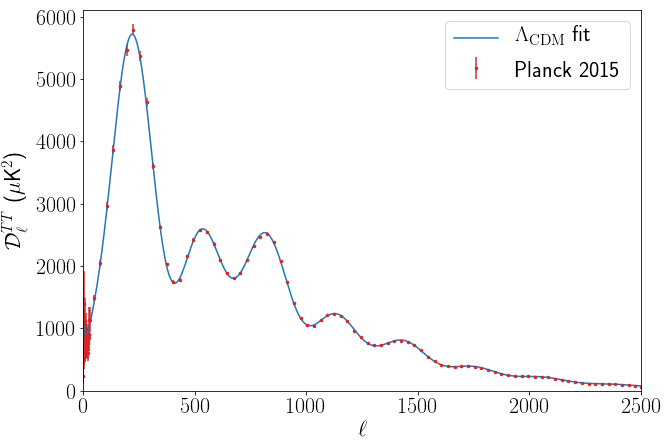

In [68]:
plt.plot(xt, yt, label=r'$\Lambda_{\rm CDM}$ fit')
plt.errorbar(x, y, dy, marker='.', markersize=5, ls='None', label='Planck 2015', color='C3')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\mathcal{D}^{TT}_{\ell}$ ($\mu$K$^2$)')
plt.xlim(0, 2500)
plt.ylim(0, 6100)
